In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('inferences.csv', sep=',', index_col=0)
noises = df['NOISE'].drop_duplicates().tolist()
datasets = df['DATASET'].drop_duplicates().tolist()
models = df['MODEL'].drop_duplicates().tolist()
df

,NOISE,DATASET,MODEL,ERR_AVG,ERR_STD,ERR_MAX,ERR_MIN,LOG_STD
0,0.0,SIMULATION_00_03,FF_200,0.003097,0.003242,0.007659,0.000428,1.193453
1,0.0,SIMULATION_00_03,FF_400,0.000288,0.000059,0.000366,0.000223,0.203700
2,0.0,SIMULATION_00_03,FF_800,0.000247,0.000108,0.000368,0.000107,0.524388
3,0.0,SIMULATION_00_03,FF_1600,0.000077,0.000031,0.000107,0.000034,0.501840
4,0.0,SIMULATION_00_03,PIDNN_200,0.000072,0.000071,0.000173,0.000021,0.975969
...,...,...,...,...,...,...,...,...
100,0.1,SIMULATION_00_40,FF_800,0.001914,0.000726,0.002725,0.000964,0.438649
101,0.1,SIMULATION_00_40,FF_1600,0.001189,0.000559,0.001731,0.000419,0.626502
102,0.1,SIMULATION_00_40,PIDNN_200,0.000815,0.000194,0.001079,0.000617,0.231855
103,0.1,SIMULATION_00_40,PIDNN_400,0.000595,0.000281,0.000916,0.000232,0.579955


In [2]:
def plot_setup(dimr, dimc, xlabel, suptitle, ylim, hide_last=False):
    fig, axs = plt.subplots(dimr, dimc, sharey=True)
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    plt.ylim(0, ylim)  
    fig.suptitle(suptitle, fontsize=24)
    for ax in axs.flat:
        ax.set(xlabel=xlabel, ylabel='-log(relative MSE)')
        ax.label_outer()
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left() 
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
    if hide_last: axs.flat[-1].set_visible(False)
    return fig, axs

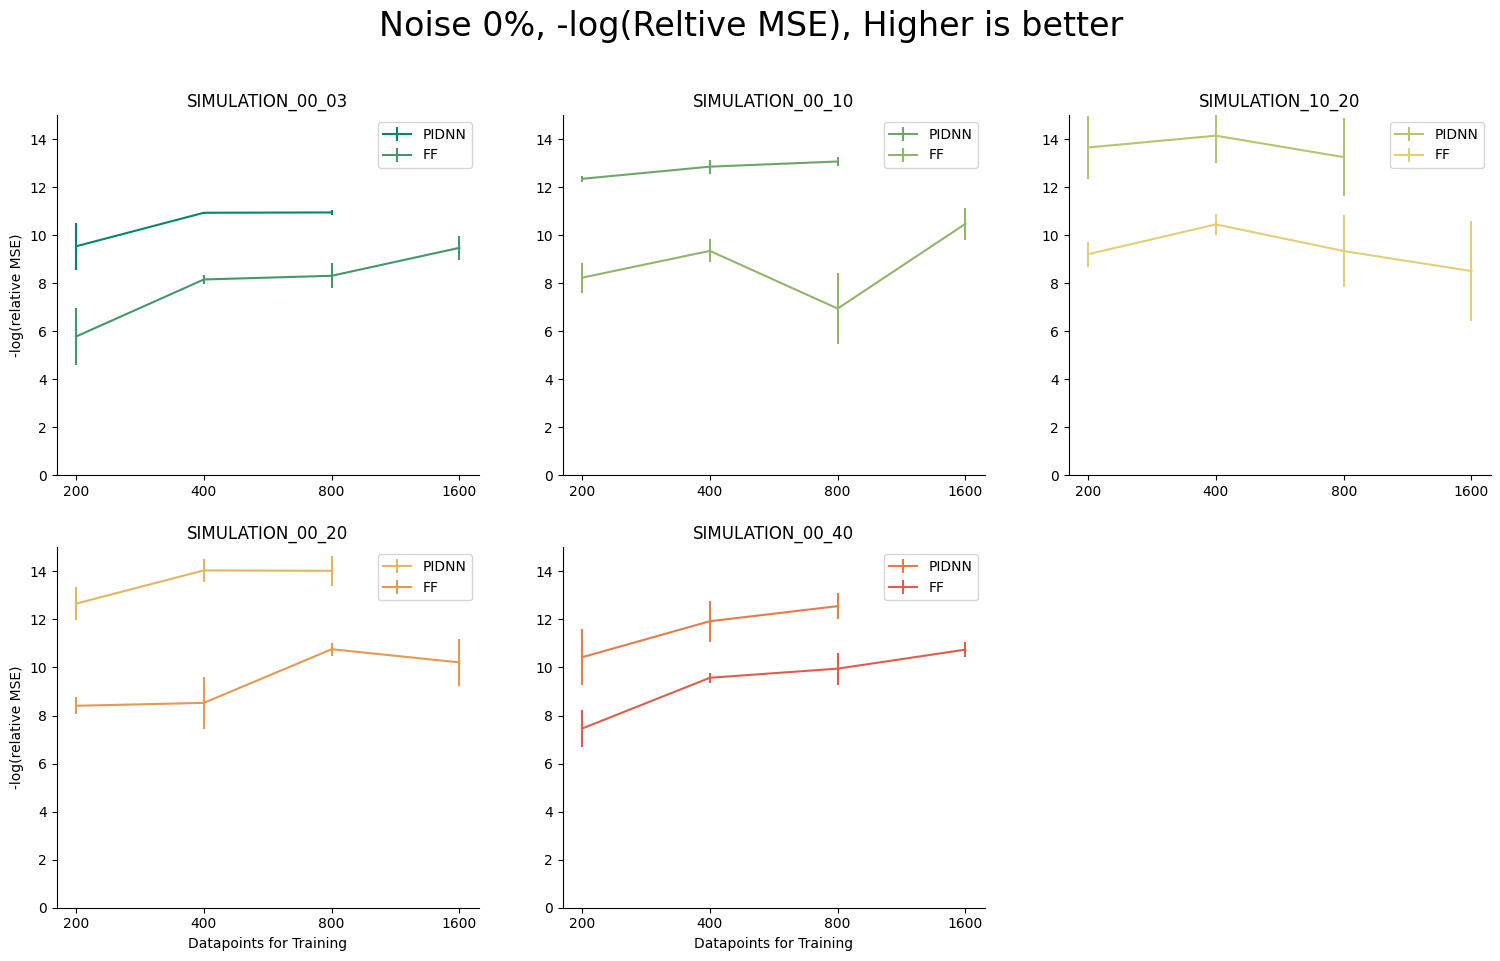

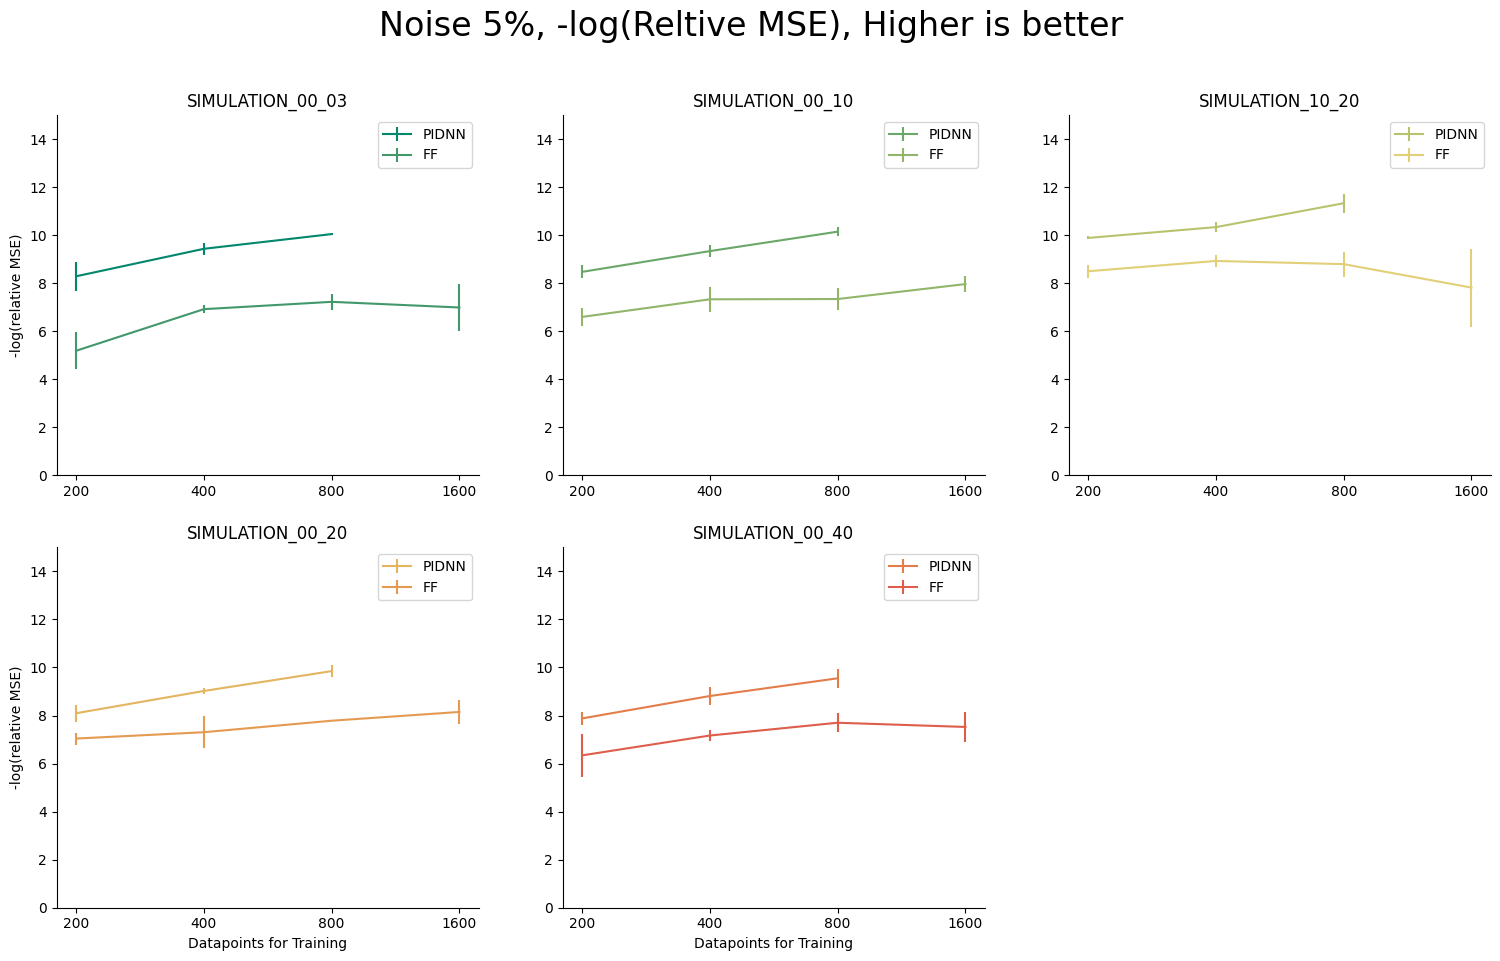

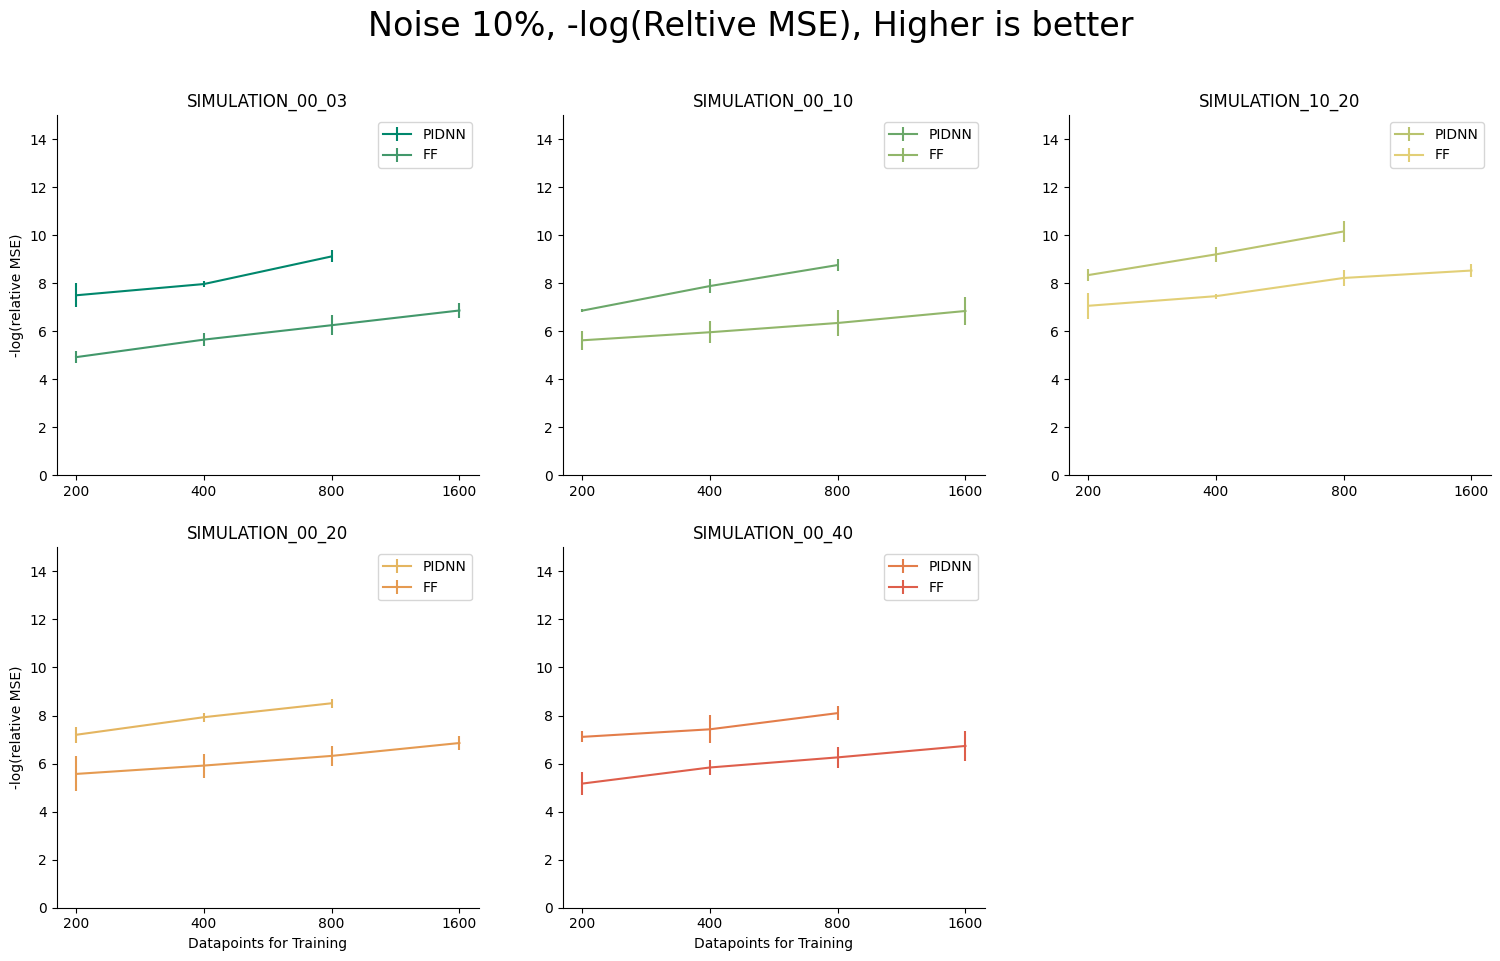

In [3]:
colors = ["#00876c","#42986b","#6aa769","#91b66a","#b9c36e","#e2cf77","#e4b560","#e59a51","#e37d4a","#de5e4b","#d43d51"]

for noise in noises:
    color_iter = 0

    fig, axs = plot_setup(2, 3, xlabel='Datapoints for Training', suptitle=f'Noise {int(100*noise)}%, -log(Reltive MSE), Higher is better', ylim=15, hide_last=True)
    
    for ind, dataset in enumerate(datasets):
        rdf = df.loc[(df['NOISE'] == noise) & (df['DATASET'] == dataset)]

        x = [s.split('_')[-1] for s in rdf['MODEL'].tolist()]

        for nn in ['PIDNN','FF']:
            y = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'ERR_AVG'].tolist())
            yerr = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'LOG_STD'].tolist())

            axs[ind//3, ind%3].errorbar(x[:y.shape[0]], -np.log(y), yerr = yerr,
                        label =nn, color=colors[color_iter])
            color_iter = (color_iter + 1)%len(colors)
        
        axs[ind//3, ind%3].legend(loc ='upper right')

        axs[ind//3, ind%3].set_title(f'{dataset}')
        fig.show()

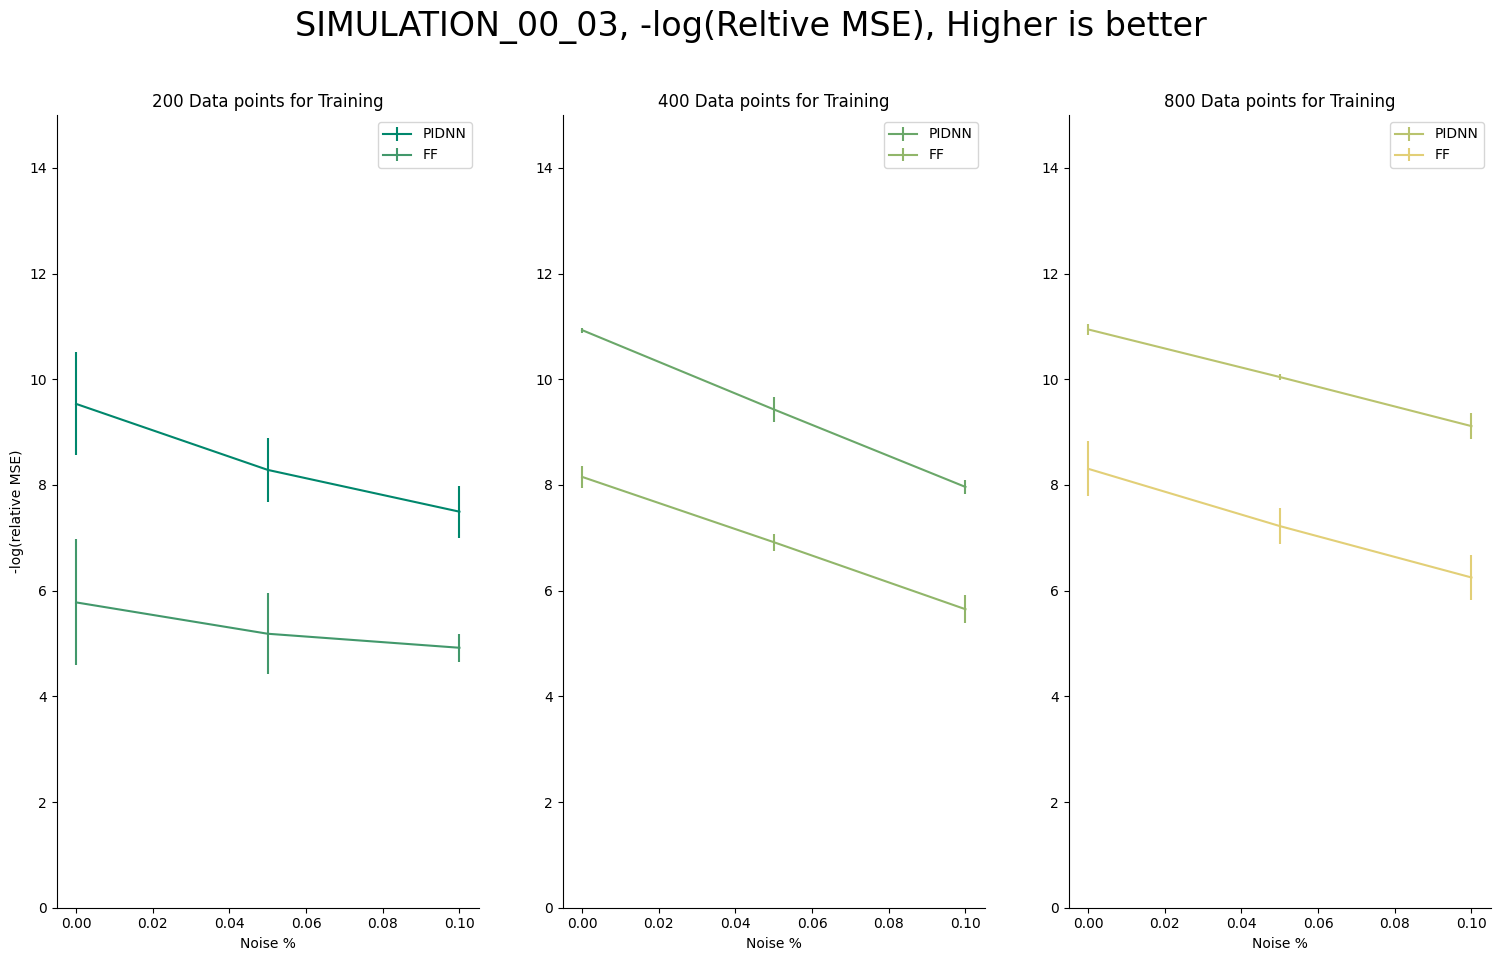

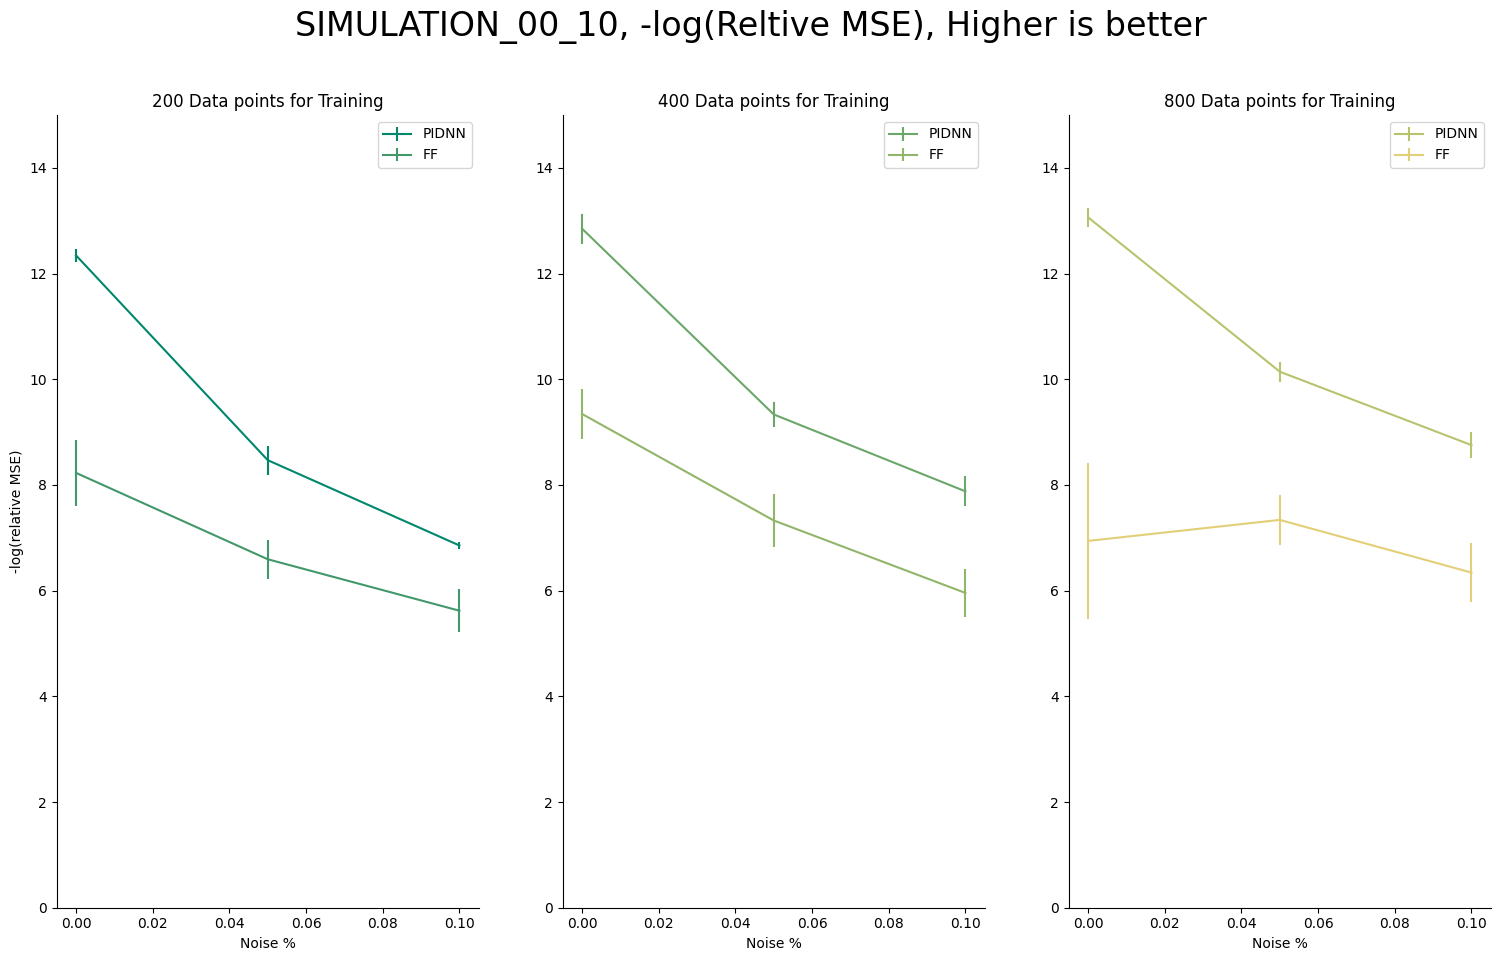

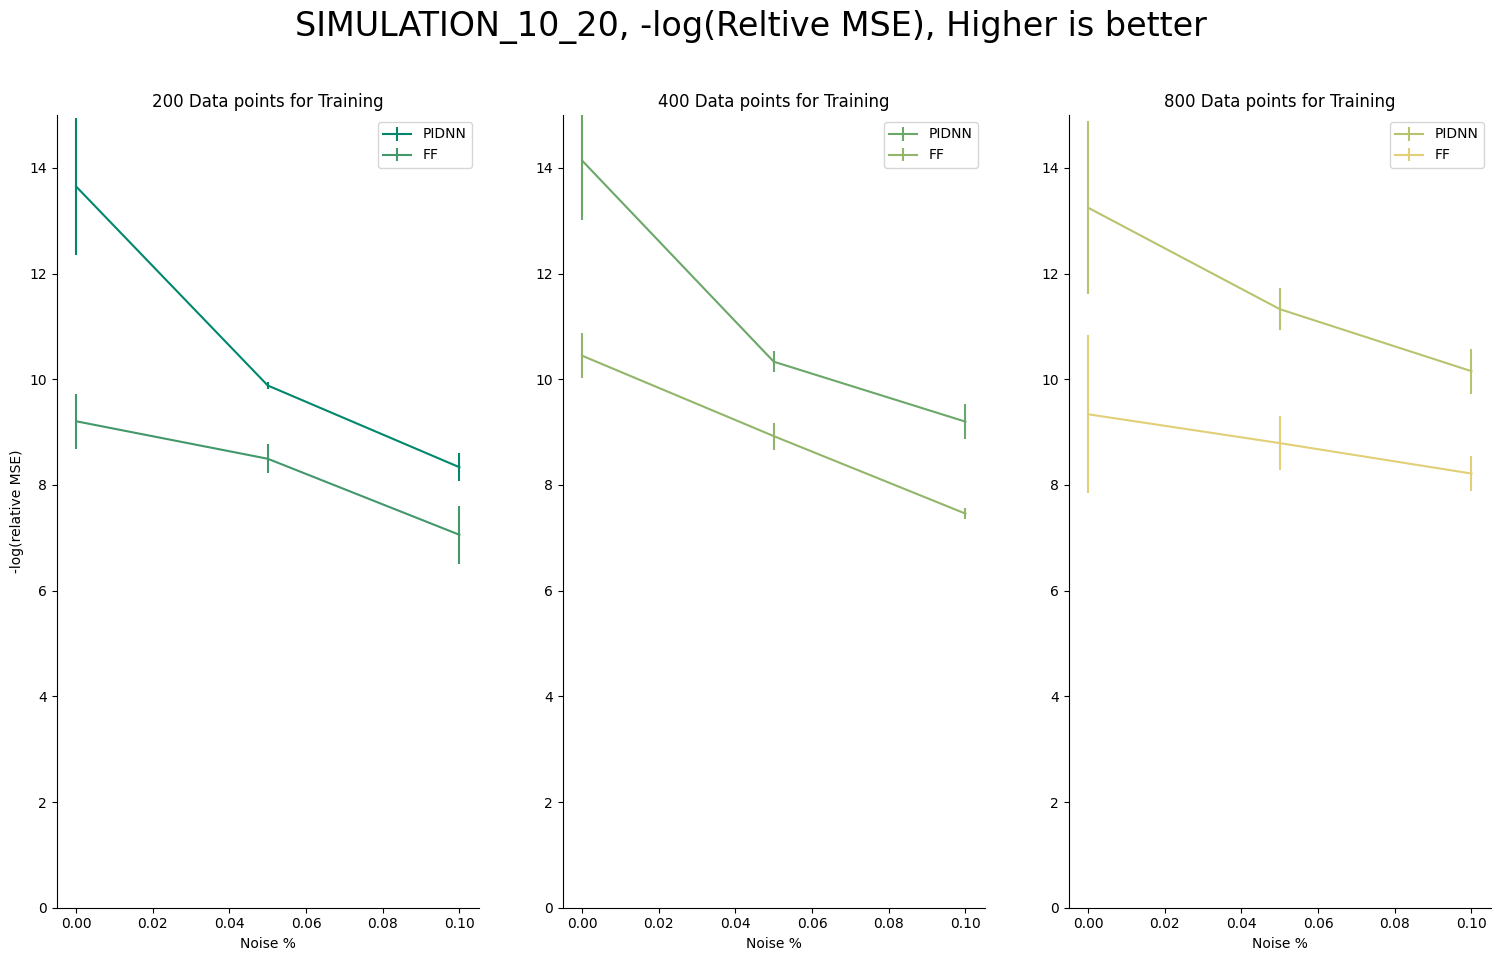

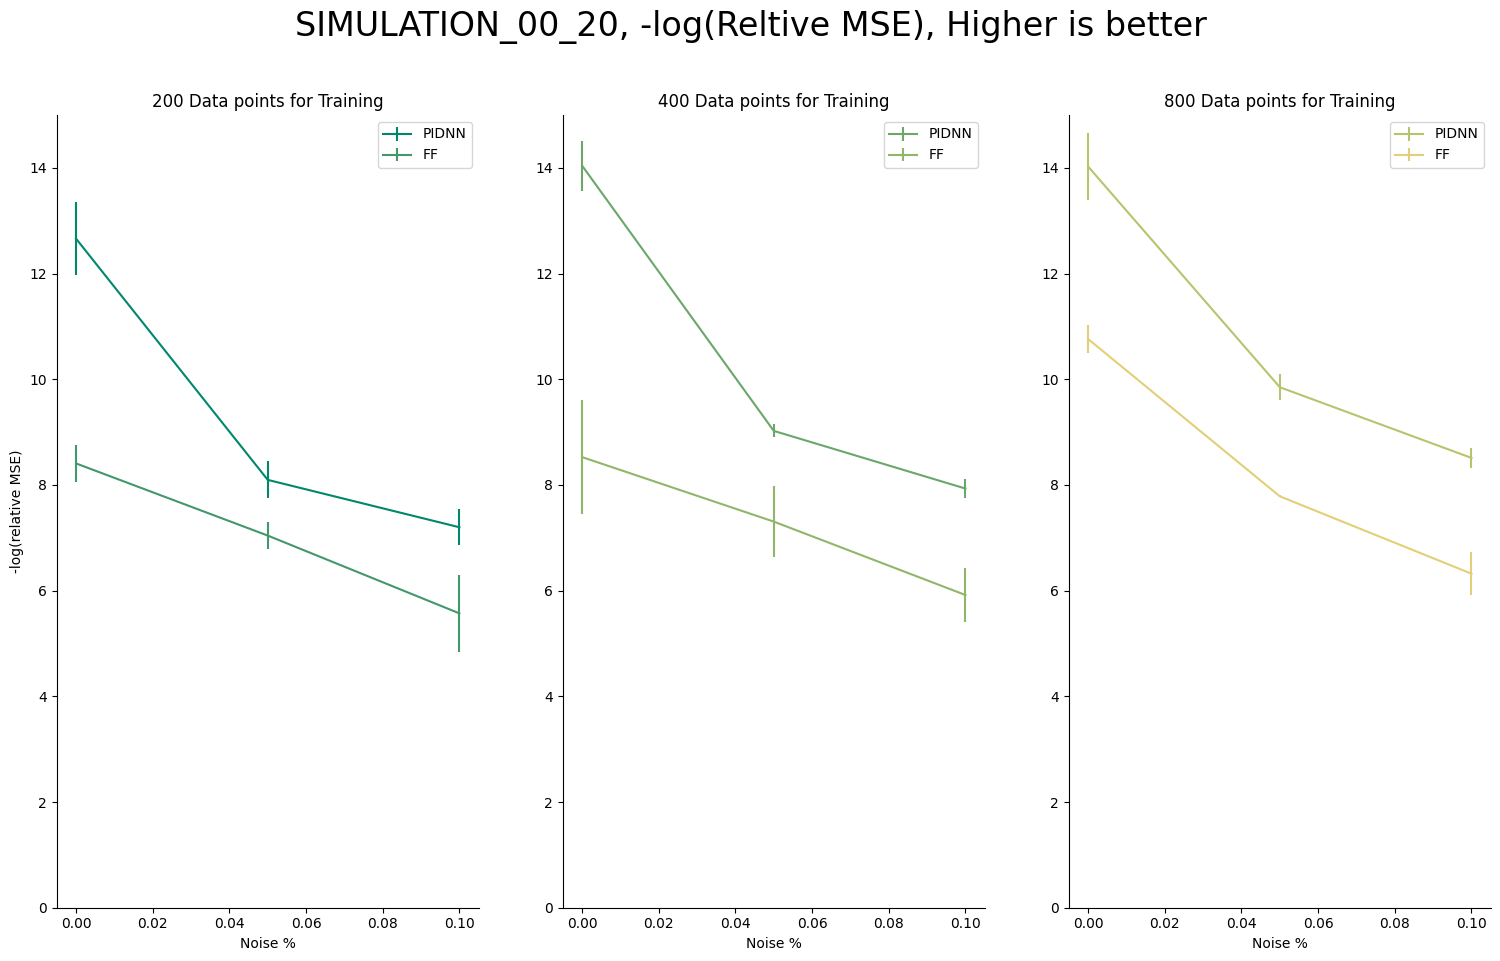

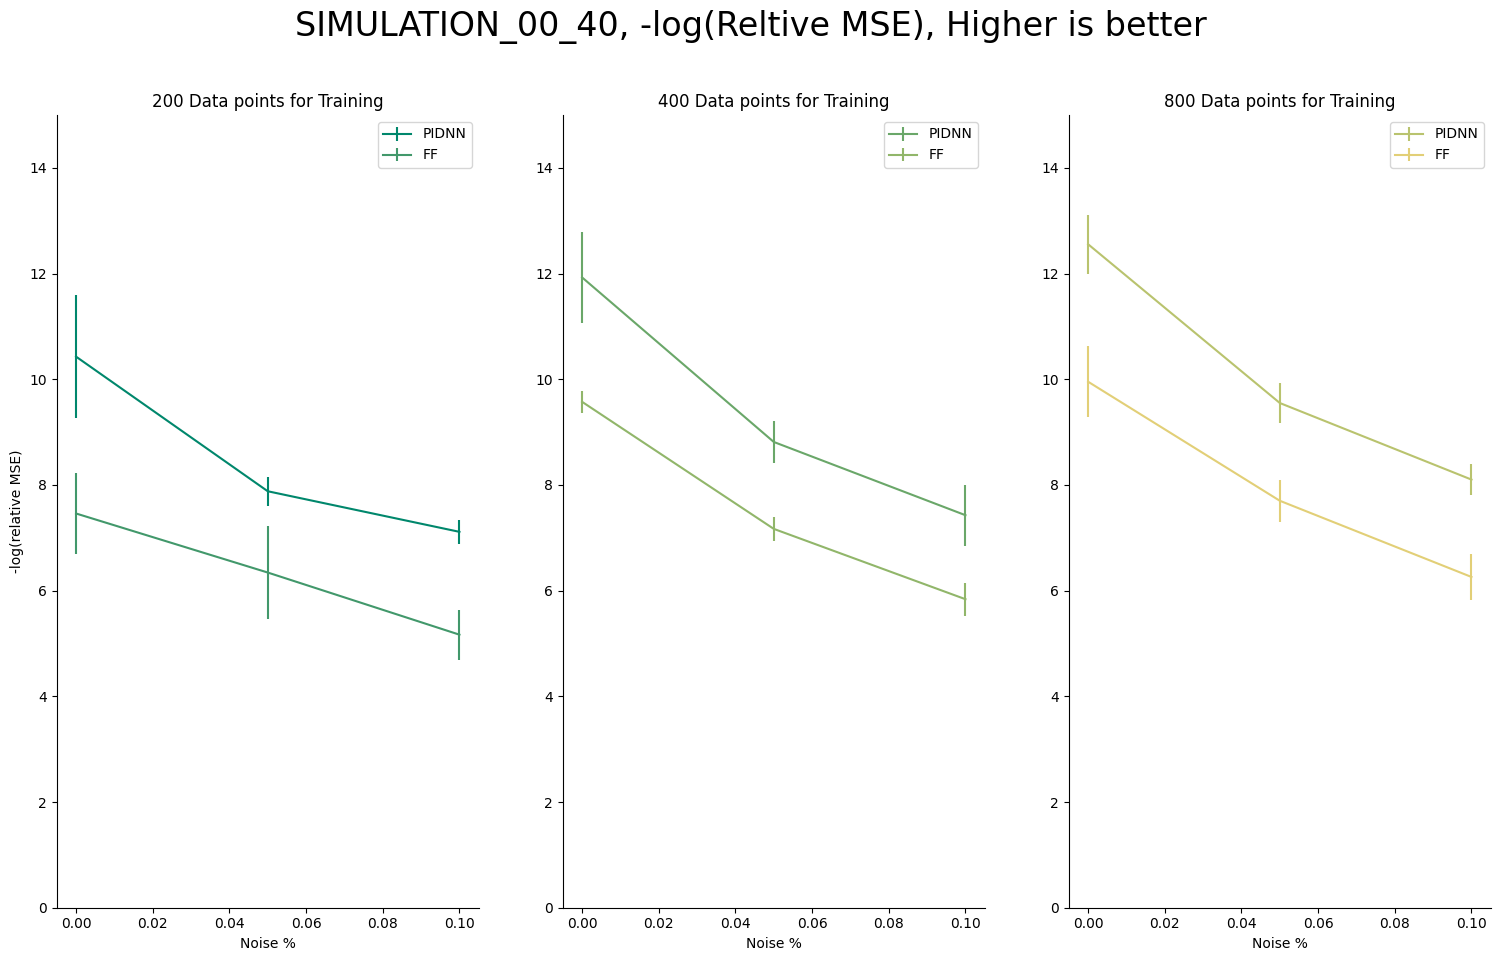

In [5]:
colors = ["#00876c","#42986b","#6aa769","#91b66a","#b9c36e","#e2cf77","#e4b560","#e59a51","#e37d4a","#de5e4b","#d43d51"]
possible_Nu = list(set([int(s.split('_')[-1]) for s in models]))
possible_Nu.sort() # N_u = number of data points
possible_Nu = [str(s) for s in possible_Nu]

for dataset in datasets:
    color_iter = 0

    fig, axs = plot_setup(1, 3, xlabel='Noise %', suptitle=f'{dataset}, -log(Reltive MSE), Higher is better', ylim=15)
    
    for ind, Nu in enumerate(possible_Nu[:-1]):
        rdf = df.loc[(df['DATASET'] == dataset) & (df['MODEL'].str.endswith(Nu))]

        x = noises

        for nn in ['PIDNN','FF']:
            y = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'ERR_AVG'].tolist())
            yerr = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'LOG_STD'].tolist())

            axs[ind%3].errorbar(x[:y.shape[0]], -np.log(y), yerr = yerr,
                        label =nn, color=colors[color_iter])
            color_iter = (color_iter + 1)%len(colors)
        
        axs[ind%3].legend(loc ='upper right')

        axs[ind%3].set_title(f'{Nu} Data points for Training')
        fig.show()